## EE4140 Assignment II
@author: Ayush Mukund Jamdar EE20B018

LMMSE based Equalization.
We discuss two different techniques - 
1. LMMSE based Linear Equaliser (Section 1)
2. Decision Feedback Equaliser (Section 2)

**NOTE**:
- The Assignment is described in the **report** attached with the submission.
- Since the report is handwritten, there are two report files.
- One, is a pdf that has some lines broken into two pages.
- Two, to help read that, I have also attached a .png file of the same report. This is a single one page image of the report.

### 1. LMMSE based Linear Equaliser

#### 1.0 Problem Statement

In the linear equaliser, we set up an $N^{th}$ order Wiener Filter. This requires us to find -
1. The autocorrelation matrix
2. Cross correlation matrix

that minimizes the mean square error.

We will use two approaches for LMMSE - 
1. Statistical Weiner Filter
2. Time-Averaged Weiner Filter

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

Lets start with defining some important functions.

$r_k$ is calculated from $I_k$ by convolving it with the channel coefficients and noise.

In [87]:
def get_r(I_k, V_k, channel_f):
    '''
    This function models the transmission of a symbol sequence over an L-tap channel.

    I_k : The input symbol sequence.
    V_k : The noise sequence to be added to the transmitted signal.
    channel_f (list): The coefficients of the L-tap channel.

    r_k : The received signal sequence.
    '''

    # Determine the number of taps in the channel
    L = len(channel_f)

    # Pad the input symbol sequence with zeros at the beginning to account for the delay introduced by the channel
    I_k_padded = np.concatenate((np.zeros(len(channel_f)-1), I_k))

    # Convolve the padded input symbol sequence with the channel coefficients
    # The 'same' option is used to return the central part of the convolution that is the same size as I_k
    # The slicing operation selects only those parts of the convolution result that correspond to valid symbol periods
    r_k = np.convolve(I_k_padded, channel_f, 'same')[np.ceil((L-1)/2).astype(int) : -np.floor((L-1)/2).astype(int)]

    # Add the noise sequence to the transmitted signal
    r_k += V_k

    return r_k


Here, we calculate the autocorrelation matrix $R_{YY}$ and the cross correlation matrix $R_{IY}$. 

$$R_{YY} \times W_{opt} = R_{IY} $$

turns out, the autocorrelation matrix is a symmetric toeplitz matrix, thus calculating just one row is enough to find the rest of the matrix.

- We use the fact that symbol energy is given by $\sigma_I^2$
- Cross correlation matrix depends on decoding delay.

In [88]:
def get_wj(N, SNR, var_I, f_n, delta):
    """
    inputs:
    1. N = Size of Weiner Filter
    2. SNR = Signal to Noise Ratio
    3. var_I = Variance of Input Signal
    4. f_n = Channel Coefficients
    5. delta = Decision Delay

    outputs:
    1. W_opt = Optimal Weiner Filter
    2. J_min = Minimum Mean Square Error

    """
    var_V = 10**(-SNR/10) * var_I # noise variance

    # 1. Autocorrelation Matrix Ryy
    # Ryy is a symmetric Toeplitz matrix with the first row and column given by the autocorrelation of the channel

    row = np.zeros(N)
    row[0] = np.sum(np.abs(f_n)**2) * var_I + var_V
    row[1] = (f_n[0]*f_n[1] + f_n[1]*f_n[2]) * var_I
    row[2] = (f_n[0]*f_n[2]) * var_I

    R_YY = toeplitz(row)

    # 2. Cross-correlation vector R_IY
    # This vector depends on delta
    if delta == 0:
        R_IY = np.zeros(N)
        R_IY[0] = f_n[0] * var_I
    elif delta == 1:
        R_IY = np.zeros(N)
        R_IY[0] = f_n[1] * var_I
        R_IY[1] = f_n[0] * var_I
    elif delta == 2:
        R_IY = np.zeros(N)
        R_IY[0] = f_n[2] * var_I
        R_IY[1] = f_n[1] * var_I
        R_IY[2] = f_n[0] * var_I
    else:
        R_IY = np.concatenate(
            (np.zeros(delta-2),
             np.array([f_n[2], f_n[1], f_n[0]]) * var_I,
             np.zeros(N-delta-1))
            ).reshape(N,1)

    W_opt = np.matmul(np.linalg.inv(R_YY), R_IY).flatten() # optimal MMSE filter

    J_min = var_I - np.dot((np.dot(R_IY.T, np.linalg.inv(R_YY))), R_IY).flatten()

    return W_opt, J_min

Now comes the most important part - decoding. So far we obtained the WF coefficients that minimize error over the entire sequence. But we need to decode the symbols and see how the filter really performs on a new sequence.

We compare $I(k)$ with $\hat{I}(k-(N+L+\Delta-2))$ to make the decision.

In [89]:
def get_I_hat_SER(I_k, w_k, f_n, delta, var_v):
    '''
    Here we convolve the received sequence with the equalizer

    return: I_hat_k(k-delta)

    - last delta symbols are not decoded
    '''

    N_w = len(w_k)

    # we have used a sequence of length 50,000 + N + L - 2 
    N_samp = len(I_k)
    
    L = len(f_n) # channel length

    r_k = np.convolve(I_k, f_n)[L-1:N_samp] # done

    y_k = np.convolve(r_k, w_k)[N_w-1: N_samp-L+1] # done

    noise = np.random.normal(0, np.sqrt(var_v), N_samp-L+1)
    filter_noise = np.convolve(noise, w_k)[N_w-1: N_samp-L+1]

    y_k += filter_noise
    # Since we are performing linear operations, 
    # we can move add the noise term separately

    I_hat_k = np.zeros_like(y_k)
    # zeros of length N_samp-L+1

    # print("r_k.shape: ", r_k.shape)
    # print("yk.shape: ", y_k.shape)
    # print("I_hat_k.shape: ", I_hat_k.shape)

    # now map y_k to nearest constellation point
    dmin = 1/np.sqrt(5)

    for i in range(len(y_k)):
        if y_k[i] <= -2*dmin:
            I_hat_k[i] = -3*dmin
        elif y_k[i] <= 0:
            I_hat_k[i] = -dmin
        elif y_k[i] <= 2*dmin:
            I_hat_k[i] = dmin
        else:
            I_hat_k[i] = 3*dmin

    # now calculate SER
    SER = 0

    for i in range(N_w+L-delta-2, N_samp-delta):
        if abs(I_hat_k[i-(N_w+L-delta-2)] - I_k[i]) > 1e-3:
            SER += 1/N_samp

    return SER


Define parameters common to the problem.

In [90]:
e_symbol = 1 # average symbol energy
var_I = e_symbol
d = 1/np.sqrt(5) # unit energy

f_n = [0.8, -1, 0.6] / np.sqrt(2) # channel coefficients
L = len(f_n) # number of taps in the channel

SNR = np.arange(0, 21, 2)
sigma_range = 10**(-SNR*0.05)

#### 1.1 SWF Solution $W_{opt}$

For a WF of order $N=3$, decoding delay $\Delta =0$, we find the best filter coefficients and the minimizing MSE.

$Q1.a(1)$ Linear Estimator $N=3, \Delta=0, SNR=10dB$

In [91]:
W_opt_a1, J_min_a1 = get_wj(N=3, SNR=10, var_I=var_I, f_n=f_n, delta=0)
print(f"W_opt_a1: {W_opt_a1}")
print(f"J_min_a1: {J_min_a1}")

W_opt_a1: [0.95869858 0.80157854 0.30092483]
J_min_a1: [0.45767818]


#### 1.2 
$Q1.a(2)$ Linear Estimator $N=10, delta=0, SNR=10dB$

In [92]:
W_opt_a2, J_min_a2 = get_wj(N=10, SNR=10, var_I=var_I, f_n=f_n, delta=0)
print(f"W_opt_a2: {W_opt_a2}")
print(f"J_min_a2: {J_min_a2}")

W_opt_a2: [ 0.98162681  0.84173676  0.31296526 -0.08206659 -0.20034628 -0.13712618
 -0.03402374  0.02698237  0.03503563  0.01640834]
J_min_a2: [0.44470802]


#### 1.3
$Q1.a(3)$ Linear Estimator $N=10, delta=5, SNR=10dB$

In [93]:
W_opt_a3, J_min_a3 = get_wj(N=10, SNR=10, var_I=var_I, f_n=f_n, delta=5)
print(f"W_opt_a3: {W_opt_a3}")
print(f"J_min_a3: {J_min_a3}")

W_opt_a3: [ 0.05175672  0.18258482  0.29532074  0.17546218 -0.36100637  0.58939739
  0.64385394  0.30512781  0.01904098 -0.05445636]
J_min_a3: [0.33687414]


#### 1.4
$Q1.a(4)$ Finding the best possible choice of N and delta so that Jmin is minimized at SNR=10dB.

In [94]:
def find_best_jmin():
    N_wiener = range(3, 25)
    jmin_least = 100 # dummy value

    for n in N_wiener:
        for delta in range(0, n):
            W_opt, J_min = get_wj(N=n, SNR=10, var_I=var_I, f_n=f_n, delta=delta)
            # print(f"N: {n}, delta: {delta}, J_min: {J_min}")
            if J_min < jmin_least:
                jmin_least = J_min
                N_wiener_best = n
                delta_best = delta
                w_best = W_opt

    print(f"Best N: {N_wiener_best}, Best delta: {delta_best}, Best J_min: {jmin_least}")

    return N_wiener_best, delta_best, jmin_least, w_best

N_wiener_best, delta_best, jmin_least, w_best = find_best_jmin()

# N_best = 24
# delta_best = 12

Best N: 24, Best delta: 12, Best J_min: [0.33146584]


Thus, for the given channel, we find that the best choice of N and delta is $N=24, \Delta=12$.

#### 1.5 Measure SER for 4ary PAM

$Q1.a(5)$ Evaluate SER for the best choice of N and delta at SNR=10dB.

In [95]:
def generate_symbols(N, d):
    '''
    This function generates a sequence of N symbols with unit energy.
    '''
    I_k = np.random.choice([-3*d, -d, d, 3*d], N)
    return I_k

In [96]:
# N_wiener_best = 26
# delta_best = 12
# w_best, _ = get_wj(N=N_wiener_best, SNR=10, var_I=var_I, f_n=f_n, delta=delta_best)
N_a5 = 50000 + N_wiener_best + L - 2
I_k = generate_symbols(N_a5, d)

SER_SWF_4PAM = []
for sigma in sigma_range:
    # Generate the input symbol sequence
    var_V = sigma**2
    # Generate r_k, decode and calculate SER
    ser = (get_I_hat_SER(I_k, w_best, f_n, delta_best, var_V))
    print(f"SER: {ser:.3f} for sigma: {sigma:.3f}")

    SER_SWF_4PAM.append(ser)


SER: 0.600 for sigma: 1.000
SER: 0.570 for sigma: 0.794
SER: 0.531 for sigma: 0.631
SER: 0.497 for sigma: 0.501
SER: 0.463 for sigma: 0.398
SER: 0.433 for sigma: 0.316
SER: 0.409 for sigma: 0.251
SER: 0.388 for sigma: 0.200
SER: 0.378 for sigma: 0.158
SER: 0.372 for sigma: 0.126
SER: 0.366 for sigma: 0.100


As expected, SER falls with increasing SNR.

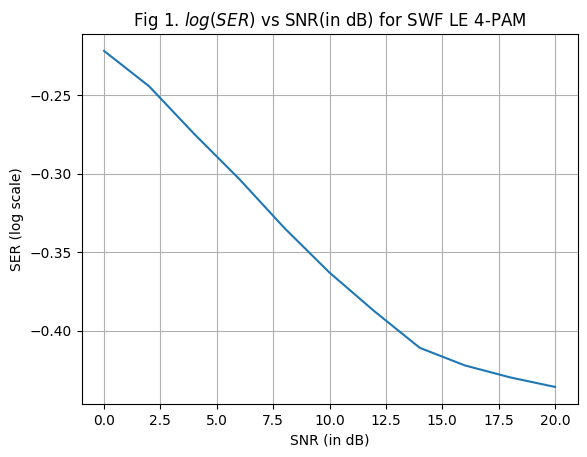

In [97]:
plt.figure()
plt.title("Fig 1. $log(SER)$ vs SNR(in dB) for SWF LE 4-PAM")
plt.grid(True)
plt.xlabel("SNR (in dB)")
plt.ylabel("SER (log scale)")
plt.plot(SNR,np.log10(SER_SWF_4PAM), label="SWF LE")
plt.show()

#### 1.6 Time Averaged Wiener Filter

$Q1.a(6)$ For $N=10$ and $\Delta=5$, build the Time Averaged Wiener Filter.

In [98]:
p_snapshots = [20, 100, 500]
jmin_snapshots = []
N_tawf = 10
delta_tawf = 5
l_tawf = len(f_n)

for p in p_snapshots:
    N_samp = p + N_tawf + l_tawf - 2
    # I_k_tawf = generate_symbols(N_samp, d)
    I_k_tawf = np.random.randint(0, 3, size=N_samp)
    I_k_tawf = (I_k_tawf*2 - 3)/2


    # # add noise with 10 dB SNR
    # I_k_tawf += np.random.normal(0,sigma_range[5],size=N_samp)

    r_tawf = np.convolve(I_k_tawf, f_n)[l_tawf-1:N_samp] + np.random.normal(0,sigma_range[5],size=N_samp-l_tawf+1)

    R_tawf = np.zeros((N_tawf, N_tawf))
    P_tawf = np.zeros((N_tawf, 1))

    d_tawf = I_k_tawf[N_tawf+l_tawf-delta_tawf-2:N_samp-delta_tawf]

    for i in range(p):
        r_k = np.flip(r_tawf[i:i+N_tawf]).reshape(N_tawf, 1)
        R_tawf += np.matmul(r_k, r_k.T) 
        P_tawf += r_k * d_tawf[i] 
    
    R_tawf /= p
    P_tawf /= p

    w_tawf = np.matmul(np.linalg.inv(R_tawf), P_tawf).flatten()
    jmin = var_I - np.matmul(P_tawf.T, np.matmul(np.linalg.inv(R_tawf), P_tawf)).flatten()
    jmin_snapshots.append(jmin)

    print(f"Jmin for p={p}: {jmin}")   



Jmin for p=20: [0.64368874]
Jmin for p=100: [0.31736756]
Jmin for p=500: [0.33933393]


#### 1.7 Construct TAWF for 4-PAM

In [99]:
N_tawf_best = 24
delta_tawf_best = 12

p = 500
N_samp = p + N_tawf_best + l_tawf - 2
I_k_tawf = generate_symbols(N_samp, d)

# # add noise with 10 dB SNR
# I_k_tawf += np.random.normal(0,sigma_range[5],size=N_samp)

r_tawf = np.convolve(I_k_tawf, f_n)[l_tawf-1:N_samp] + np.random.normal(0,sigma_range[5],size=N_samp-l_tawf+1)

R_tawf = np.zeros((N_tawf_best, N_tawf_best))
P_tawf = np.zeros((N_tawf_best, 1))

d_tawf = I_k_tawf[N_tawf_best+l_tawf-delta_tawf_best-2:N_samp-delta_tawf_best]

for i in range(p):
    r_k = np.flip(r_tawf[i:i+N_tawf_best]).reshape(N_tawf_best, 1)
    R_tawf += np.matmul(r_k, r_k.T) 
    P_tawf += r_k * d_tawf[i] 

R_tawf /= p
P_tawf /= p

w_tawf = np.matmul(np.linalg.inv(R_tawf), P_tawf).flatten()
jmin_tawf = var_I - np.matmul(P_tawf.T, np.matmul(np.linalg.inv(R_tawf), P_tawf)).flatten()


print(f"Jmin for p={p}: {jmin}")   


Jmin for p=500: [0.33933393]


Now decoding.

In [100]:
N_samp = 50000 + N_tawf_best + l_tawf - 2
I_k = generate_symbols(N_samp, d)

SER_TAWF = []
for sigma in sigma_range:
    # Generate the input symbol sequence
    var_V = sigma**2
    # Generate r_k, decode and calculate SER
    ser = (get_I_hat_SER(I_k, w_tawf, f_n, delta_tawf_best, var_V))
    print(f"SER: {ser:.3f} for sigma: {sigma:.3f}")

    SER_TAWF.append(ser)

SER: 0.598 for sigma: 1.000
SER: 0.562 for sigma: 0.794


SER: 0.534 for sigma: 0.631
SER: 0.503 for sigma: 0.501
SER: 0.469 for sigma: 0.398
SER: 0.442 for sigma: 0.316
SER: 0.421 for sigma: 0.251
SER: 0.407 for sigma: 0.200
SER: 0.398 for sigma: 0.158
SER: 0.390 for sigma: 0.126
SER: 0.385 for sigma: 0.100


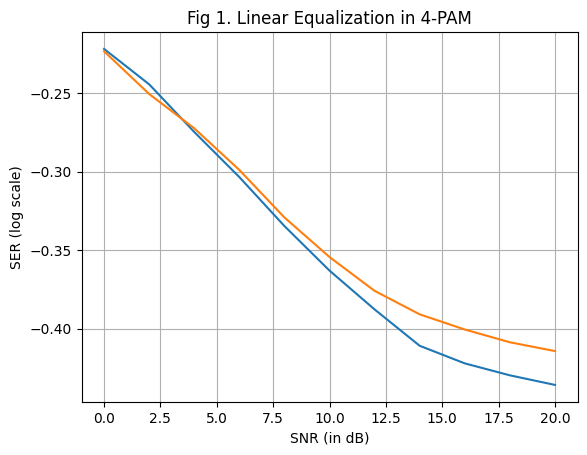

In [101]:
# Plot SERs
plt.figure()
plt.title("Fig 1. Linear Equalization in 4-PAM")
plt.grid(True)
plt.xlabel("SNR (in dB)")
plt.ylabel("SER (log scale)")
plt.plot(SNR,np.log10(SER_SWF_4PAM), label="SWF")
plt.plot(SNR,np.log10(SER_TAWF), label="TAWF")
plt.show()


### 2. Decision Feedback Equaliser
- $L=6$ taps filter. 
- Binary PAM
- $SNR=10dB$

Lets begin with setting up the problem. 

In [102]:
fn_6taps = np.array([1,-0.95,0.5,0.15,-0.2,-0.1])
C = np.sqrt(np.sum(np.abs(fn_6taps)**2))
fn_6taps /= C
print("C = ", C)

C =  1.4916433890176297


Getting the autocorrelation matrix when the channel coefficients and SNR are known is straightforward. We compute one row of the matrix and then use the toeplitz property to get the entire matrix.

In [103]:
def get_autocorrelation(N, f_n, var_I, var_V):
    first_row = np.zeros(N)
    first_row[0] = np.sum(np.abs(f_n)**2)*var_I + var_V
    first_row[1] = (f_n[0]*f_n[1] + f_n[1]*f_n[2] + f_n[2]*f_n[3] + f_n[3]*f_n[4] + f_n[4]*f_n[5])*var_I
    first_row[2] = (f_n[0]*f_n[2] + f_n[1]*f_n[3] + f_n[2]*f_n[4] + f_n[3]*f_n[5])*var_I
    first_row[3] = (f_n[0]*f_n[3] + f_n[1]*f_n[4] + f_n[2]*f_n[5])*var_I
    first_row[4] = (f_n[0]*f_n[4] + f_n[1]*f_n[5])*var_I
    first_row[5] = (f_n[0]*f_n[5])*var_I
    first_col = first_row

    R = toeplitz(c=first_col,r=first_row)
    # print(R[0][0])

    return R


The cross correlation matrix depends on $\Delta$ in a way that is lengthy to implement in code in a generalized fashion. So we stick to our situation where the channel filter length is known (6) and take nested cases over $\Delta$.

In [104]:
def get_cross_corr(N,delta,f_n,var_I):
  if delta==0:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[0]*var_I

  elif delta==1:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[1]*var_I
    R_IY[1] = f_n[0]*var_I

  elif delta==2:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[2]*var_I
    R_IY[1] = f_n[1]*var_I
    R_IY[2] = f_n[0]*var_I

  elif delta==3:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[3]*var_I
    R_IY[1] = f_n[2]*var_I
    R_IY[2] = f_n[1]*var_I
    R_IY[3] = f_n[0]*var_I

  elif delta==4:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[4]*var_I
    R_IY[1] = f_n[3]*var_I
    R_IY[2] = f_n[2]*var_I
    R_IY[3] = f_n[1]*var_I
    R_IY[4] = f_n[0]*var_I

  elif delta==5:
    R_IY = np.zeros(N)
    R_IY[0] = f_n[5]*var_I
    R_IY[1] = f_n[4]*var_I
    R_IY[2] = f_n[3]*var_I
    R_IY[3] = f_n[2]*var_I
    R_IY[4] = f_n[1]*var_I
    R_IY[5] = f_n[0]*var_I

  else:
    R_IY = np.zeros(N-delta+5)
    R_IY[0] = f_n[5]*var_I
    R_IY[1] = f_n[4]*var_I
    R_IY[2] = f_n[3]*var_I
    R_IY[3] = f_n[2]*var_I
    R_IY[4] = f_n[1]*var_I
    R_IY[5] = f_n[0]*var_I

    zeros_array = np.zeros(delta-5)
    R_IY = np.concatenate((zeros_array,R_IY))

  return R_IY

In [105]:
def get_wj_6taps(N=20, SNR=10, var_I=var_I, f_n=fn_6taps, delta=9):
    
    var_V = 10**(-SNR/10) * var_I
    ryy = get_autocorrelation(N, f_n, var_I, var_V)
    riy = get_cross_corr(N, delta, f_n, var_I)

    # print(ryy[0])

    W_opt = np.matmul(np.linalg.inv(ryy), riy).flatten() # optimal MMSE filter

    J_min = var_I - np.dot((np.dot(riy.T, np.linalg.inv(ryy))), riy).flatten()

    return W_opt, J_min

    

#### 2.1 SWF Linear Equalizer
$Q1.b(1)$ Linear Estimator $N=20, \Delta=9, SNR=10dB$

In [106]:
W_opt_b1, J_min_b1 = get_wj_6taps(N=20, SNR=10, var_I=var_I, f_n=fn_6taps, delta=9)
print(f"W_opt_b1: {W_opt_b1}")
print(f"J_min_b1: {J_min_b1}")

W_opt_b1: [ 0.03321421  0.05267439 -0.00081687 -0.11417863 -0.169383   -0.05870056
  0.14214342  0.16677338 -0.16099218  0.81043379  0.63586708  0.27020775
 -0.10735201 -0.15489229  0.01486429  0.14368484  0.12332243  0.02201675
 -0.04089758 -0.03274768]
J_min_b1: [0.26472843]


#### 2.2
We analyze the performance of a DFE for $10dB$. 
- $N_1=15$ Feedforward Filter $W_{FF}
- $N_2=5$ Feedback Filer 
- $\Delta=1$ Decoding Delay

Let's calculate the DFE autocorrelation matrix from the autocorrelation matrices of FF and FB filters.

In [107]:
N1 = 15
N2 = 5

R_YY_FF = get_autocorrelation(N=N1, f_n=fn_6taps, var_I=var_I, var_V=sigma_range[5]**2)
R_YY_FB = np.eye(N2)*var_I # identity matrix

def calculate_autocorrelation_dfe(R_YY_FF, R_YY_FB, f_n, var_I, N1, N2):
    auto_corr_DFE = np.block([[R_YY_FF, np.zeros((N1, N2))], [np.zeros((N2, N1)), R_YY_FB]])

    rect_mat = np.zeros((N1,N2))
    rect_mat[0] = var_I*np.array([f_n[2],f_n[3],f_n[4],f_n[5],0])
    rect_mat[1] = var_I*np.array([f_n[1],f_n[2],f_n[3],f_n[4],f_n[5]])
    rect_mat[2] = var_I*np.array([f_n[0],f_n[1],f_n[2],f_n[3],f_n[4]])
    rect_mat[3] = var_I*np.array([0,f_n[0],f_n[1],f_n[2],f_n[3]])
    rect_mat[4] = var_I*np.array([0,0,f_n[0],f_n[1],f_n[2]])
    rect_mat[5] = var_I*np.array([0,0,0,f_n[0],f_n[1]])
    rect_mat[6] = var_I*np.array([0,0,0,0,f_n[0]])

    rect_mat = -1.0 * rect_mat

    # stack these matrices together
    auto_corr_DFE = np.block(
                            [[auto_corr_DFE[:15, :15], rect_mat],\
                            [np.transpose(rect_mat), R_YY_FB]]
                        )

    return auto_corr_DFE

auto_corr_DFE = calculate_autocorrelation_dfe(R_YY_FF, R_YY_FB, fn_6taps, var_I, N1, N2)

In [108]:
cross_correlation_DFE = np.zeros((N1+N2,1))
cross_correlation_DFE[0][0] = var_I*fn_6taps[1]
cross_correlation_DFE[1][0] = var_I*fn_6taps[0]

W_opt_b2 = np.matmul(np.linalg.inv(auto_corr_DFE), cross_correlation_DFE)
W_opt_b2 = W_opt_b2.flatten()

J_min_DFE = var_I - np.matmul((W_opt_b2), cross_correlation_DFE)
J_min_DFE = J_min_DFE.flatten()

print(f"W_opt_b2: {W_opt_b2}")
print(f"J_min_DFE: {J_min_DFE}")

W_opt_b2: [-1.85981122e-01  1.07563298e+00  9.56715244e-16 -7.81224584e-17
  1.36907076e-16 -1.08624139e-16  1.61597812e-16  2.01733618e-16
  1.56999275e-16  1.98280136e-17 -5.96079390e-17 -2.82649129e-17
  3.32280302e-17  5.09387469e-17  2.77774793e-17 -7.47391705e-01
  3.41850691e-01  1.33102304e-01 -1.31752995e-01 -7.21105991e-02]
J_min_DFE: [0.16044608]


Hence we found the $J_{min}$ for a DFE. 
Comparing the results - 
- SWF LE $J_{min}=0.26$
- SWF DFE $J_{min}=0.16$

Clearly, a Decision Feedback Equaliser promises more accurate decoding.

#### 2.3
$Q2.b(3)$ 2-PAM symbols for calculating SER for Statistical Wiener Filter and Decision Feedback Equalizer.

#### 2.3.1 SER for Linear Equalizer

First, we recall the function that we had used to find $SER$ for 4-PAM earlier in the linear equalizer. 

In [109]:
# Decode symbols for SWF Linear Equalizer [2-PAM]
def get_SER_BPAM_lineareq(I_k, w_k, f_n, delta, var_v):
    '''
    Here we convolve the received sequence with the equalizer

    inputs:
    - I_k = input sequence (known)
    - w_k = weiner filter coefficients obtained in (2.1)
    - f_n = 6 tap filter coefficients
    - delta = 9 decoding delay 
    
    outputs:
    - SER for this simulation setup

    '''

    N_w = len(w_k)
    N_samp = len(I_k)
    L = len(f_n) # channel length

    r_k = np.convolve(I_k, f_n)[L-1:N_samp] # done

    y_k = np.convolve(r_k, w_k)[N_w-1: N_samp-L+1] # done

    noise = np.random.normal(0, np.sqrt(var_v), N_samp-L+1)
    filter_noise = np.convolve(noise, w_k)[N_w-1: N_samp-L+1]

    y_k += filter_noise

    I_hat_k = np.zeros_like(y_k)

    # print("r_k.shape: ", r_k.shape)
    # print("yk.shape: ", y_k.shape)
    # print("I_hat_k.shape: ", I_hat_k.shape)

    # now map y_k to nearest constellation point
    dmin_bpam = 1

    for i in range(len(y_k)):
        if y_k[i] <= 0:
          I_hat_k[i] = -dmin_bpam
        else:
          I_hat_k[i] = dmin_bpam

    # now calculate SER
    SER = 0

    for i in range(N_w+L-delta-2, N_samp-delta):
        if abs(I_hat_k[i-(N_w+L-delta-2)] - I_k[i]) > 1e-3:
            SER += 1/N_samp

    return SER

In [110]:
# Generate Symbols
dmin_bpam = 1
L_bpam = len(fn_6taps)
N_b3 = 50000+N1+L_bpam-2
I_k_bpam = np.random.choice([-dmin_bpam, dmin_bpam], N_b3)

# Calculate SER for SWF LE
SER_SWF_LE = []
for sigma in sigma_range:
    # Generate the input symbol sequence
    # N_a5 = 50000 + N_wiener_best + L - 2 # 50021 number of symbols
    var_V = sigma**2

    # Generate r_k, decode and calculate SER
    ser = (get_SER_BPAM_lineareq(I_k_bpam, W_opt_b1, fn_6taps, delta=9, var_v=var_V))
    print(f"SER: {ser} for sigma: {sigma}")

    SER_SWF_LE.append(ser)

SER: 0.2639397029129656 for sigma: 1.0
SER: 0.21759731302109728 for sigma: 0.7943282347242815
SER: 0.16927567524342438 for sigma: 0.6309573444801932


SER: 0.1209340450628674 for sigma: 0.5011872336272722
SER: 0.07900997620903631 for sigma: 0.3981071705534972
SER: 0.04788180491413169 for sigma: 0.31622776601683794
SER: 0.025530298486575544 for sigma: 0.25118864315095796
SER: 0.013155001099581985 for sigma: 0.19952623149688792
SER: 0.006737439772886255 for sigma: 0.15848931924611134
SER: 0.003358723684999706 for sigma: 0.12589254117941673
SER: 0.0019192706771426885 for sigma: 0.1


#### 2.3.2 SER for DFE

Now the real part, we measure SER for this BPAM setup using the Decision Feedback Equalizer. We had found the comprehensive weights matrix in $2.2$

In [111]:
w_ff = W_opt_b2[:N1]
w_fb = W_opt_b2[N1:N1+N2]

In [112]:
# Decode SWF DFE
def get_SER_BPAM_DFE(I_k, w_ff, w_fb, f_n, delta, var_v):
    '''
    inputs:
    - I_k = input sequence (known)
    - w_ff = feedforward filter coefficients
    - w_fb = feedback filter coefficients
    - f_n = 6 tap filter coefficients
    - delta = 1 decoding delay z^-1
    
    outputs:
    - SER for this simulation setup
    
    '''

    N1 = len(w_ff) # 15
    N_samp = len(I_k)
    L = len(f_n) # channel length

    noise = np.random.normal(0, np.sqrt(var_v), N_samp-L+1)
    r_k = np.convolve(I_k_bpam, f_n)[L-1:N_samp] + noise # done

    z1 = np.convolve(w_ff, r_k)[N1-1: N_samp-L+1] # done

    # filter_noise = np.convolve(noise, w_ff)[N1-1: N_samp-L+1]

    dmin = 1 # 2 pam
    feedback_I = np.zeros(N2) # these are the filter coefficients of the feedback vector
    y_k_dfe = np.zeros(N_samp-(N1+L-2))
    I_hat_k_dfe = np.zeros(N_samp-(N1+L-2))

    for i in range(N_samp-(N1+L-2)):
      z2 = np.dot(w_fb, feedback_I.T)
      y_k_dfe[i] = z1[i] - z2

      if y_k_dfe[i] < 0:
        I_hat_k_dfe[i] = -dmin
      else:
        I_hat_k_dfe[i] = dmin

      feedback_I = np.concatenate(([I_hat_k_dfe[i]], feedback_I[:-1]))


    # now calculate SER
    SER = 0 

    for i in range(18, 50018):
        if I_hat_k_dfe[i-18]*I_k_bpam[i] < 0:
            # shorthand method to decode
            # possible because of BPAM
            # positive symbol would be mapped to d
            # negative to -d
            # thus same sign marks a correct decision
            SER += 1/N_samp

    return SER


In [113]:
# Calculate SER for SWF LE
SER_SWF_DFE = []
for sigma in sigma_range:
    # Generate the input symbol sequence
    # N_a5 = 50000 + N_wiener_best + L - 2 # 50021 number of symbols
    var_V = sigma**2

    # Generate r_k, decode and calculate SER
    ser = (get_SER_BPAM_DFE(I_k_bpam, w_ff, w_fb, fn_6taps, delta=9, var_v=var_V))
    print(f"SER: {ser} for sigma: {sigma}")

    SER_SWF_DFE.append(ser)

SER: 0.26755832783549716 for sigma: 1.0
SER: 0.2339111137768197 for sigma: 0.7943282347242815
SER: 0.18794857953980273 for sigma: 0.6309573444801932
SER: 0.1328095323776919 for sigma: 0.5011872336272722
SER: 0.07225254403326382 for sigma: 0.3981071705534972
SER: 0.03192786741038481 for sigma: 0.31622776601683794
SER: 0.007557128291249261 for sigma: 0.25118864315095796
SER: 0.0009196505327975377 for sigma: 0.19952623149688792
SER: 0 for sigma: 0.15848931924611134
SER: 0 for sigma: 0.12589254117941673
SER: 0 for sigma: 0.1


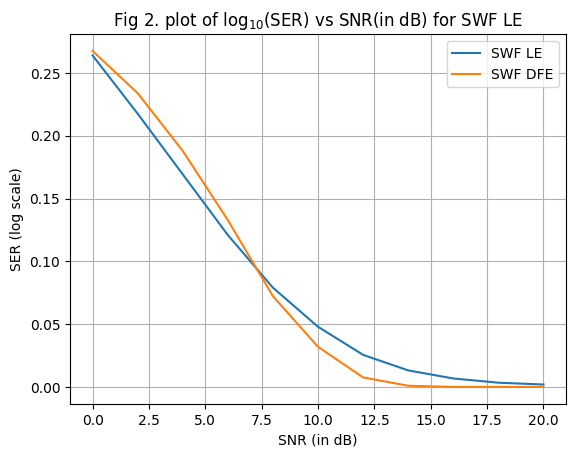

In [114]:
# Plot both SERs
plt.figure()
plt.title("Fig 2. plot of log$_{10}$(SER) vs SNR(in dB) for SWF LE")
plt.grid(True)
plt.xlabel("SNR (in dB)")
plt.ylabel("SER (log scale)")
plt.plot(SNR,(SER_SWF_LE), label="SWF LE")
plt.plot(SNR,(SER_SWF_DFE), label="SWF DFE")
plt.legend()
plt.show()


As predicted before, the Decision Feedback Equalizer performs better than the Linear equalizer.

#### 2.4 Comparing with Viterbi Decoding

We had done this in Assignment 1. Taking the SER from there directly, we get the compiled plot.

In [115]:
SER_bpam_viterbi = [
    0.22872914916596665,
    0.18638745549821992,
    0.13190527621104844,
    0.078123124924997,
    0.028241129645185808,
    0.0064402576103044125,
    0.0003800152006080243,
    0.0,
    0.0,
    0.0,
    0.0
    ]

C:\Users\USER\AppData\Local\Temp\ipykernel_25760\68077414.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNR,np.log10(SER_SWF_DFE), label="SWF DFE")
C:\Users\USER\AppData\Local\Temp\ipykernel_25760\68077414.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNR,np.log10(SER_bpam_viterbi), label='Viterbi')


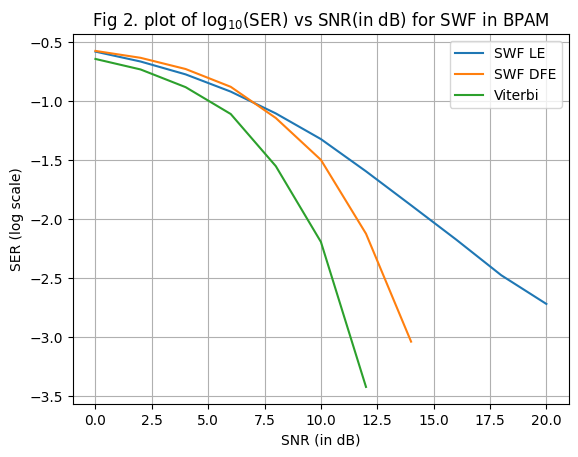

In [116]:
# Plot all decoding methods together
plt.figure()
plt.title("Fig 2. plot of log$_{10}$(SER) vs SNR(in dB) for SWF in BPAM")
plt.grid(True)
plt.xlabel("SNR (in dB)")
plt.ylabel("SER (log scale)")
plt.plot(SNR,np.log10(SER_SWF_LE), label="SWF LE")
plt.plot(SNR,np.log10(SER_SWF_DFE), label="SWF DFE")
plt.plot(SNR,np.log10(SER_bpam_viterbi), label='Viterbi')
plt.legend()
plt.show()
